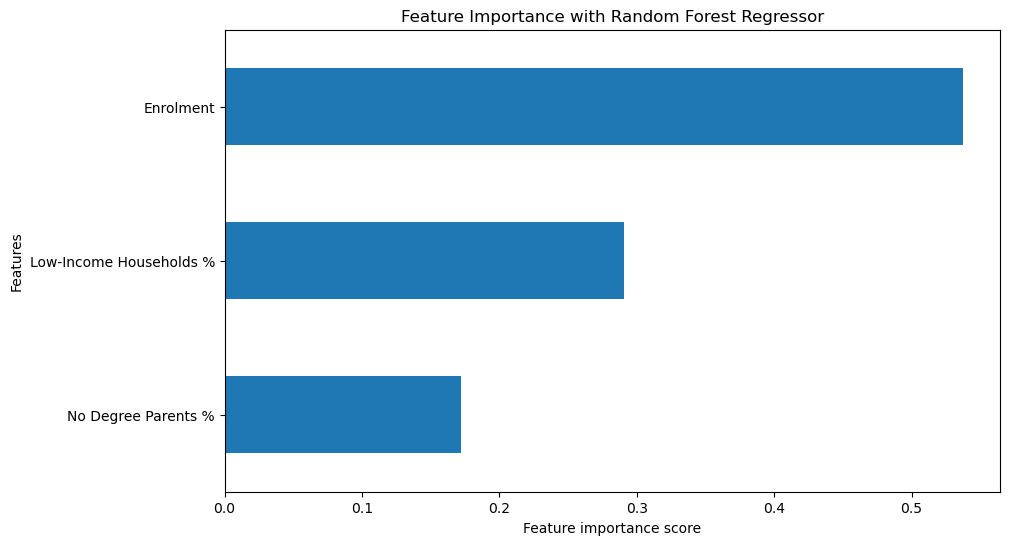

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import learning_curve

file_path = 'new_sif_data_table_2021_22prelim_en_march2024.xlsx'
data = pd.read_excel(file_path)

columns_of_interest = [
    'Percentage of School-Aged Children Who Live in Low-Income Households',
    'Percentage of Students Whose Parents Have No Degree, Diploma or Certificate',
    'Enrolment',
    'Percentage of Grade 3 Students Achieving the Provincial Standard in Reading',
    'Percentage of Grade 3 Students Achieving the Provincial Standard in Writing',
    'Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics'
]

for column in columns_of_interest:
    if 'Percentage' in column:
        data[column] = data[column].str.extract(r'(\d+\.?\d*)').astype(float) / 100.0
    elif column == 'Enrolment':
        data[column] = pd.to_numeric(data[column], errors='coerce')

data.dropna(subset=columns_of_interest, inplace=True)

data['Mean Achievement'] = data[
    ['Percentage of Grade 3 Students Achieving the Provincial Standard in Reading',
     'Percentage of Grade 3 Students Achieving the Provincial Standard in Writing',
     'Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics']
].mean(axis=1)

features = ['Percentage of School-Aged Children Who Live in Low-Income Households',
            'Percentage of Students Whose Parents Have No Degree, Diploma or Certificate',
            'Enrolment']
X = data[features]
y = data['Mean Achievement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

short_feature_names = {
    'Percentage of School-Aged Children Who Live in Low-Income Households': 'Low-Income Households %',
    'Percentage of Students Whose Parents Have No Degree, Diploma or Certificate': 'No Degree Parents %',
    'Enrolment': 'Enrolment'
}

feature_importances = pd.Series(rf_regressor.feature_importances_, index=features).rename(index=short_feature_names)

plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance with Random Forest Regressor')
plt.xlabel('Feature importance score')
plt.ylabel('Features')
plt.show()

In [2]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

R^2 Score: -0.1406
Mean Absolute Error (MAE): 0.1403
Mean Squared Error (MSE): 0.0329


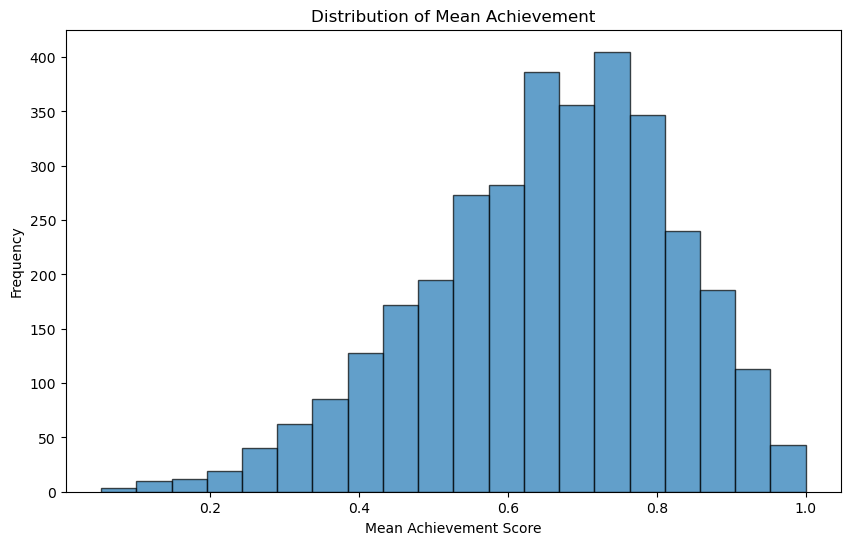

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(data['Mean Achievement'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Mean Achievement')
plt.xlabel('Mean Achievement Score')
plt.ylabel('Frequency')
plt.show()

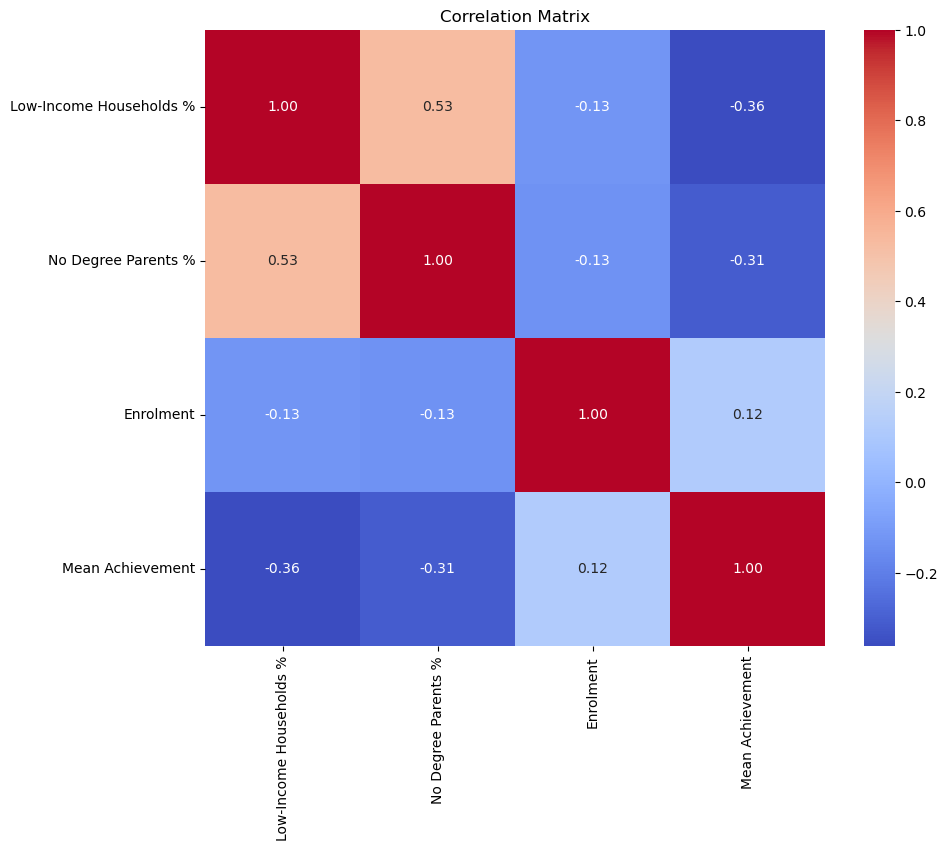

In [4]:
feature_renames = {
    'Percentage of School-Aged Children Who Live in Low-Income Households': 'Low-Income Households %',
    'Percentage of Students Whose Parents Have No Degree, Diploma or Certificate': 'No Degree Parents %',
    'Enrolment': 'Enrolment',
    'Mean Achievement': 'Mean Achievement'
}

data_renamed = data.rename(columns=feature_renames)

correlation_matrix_renamed = data_renamed[feature_renames.values()].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_renamed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

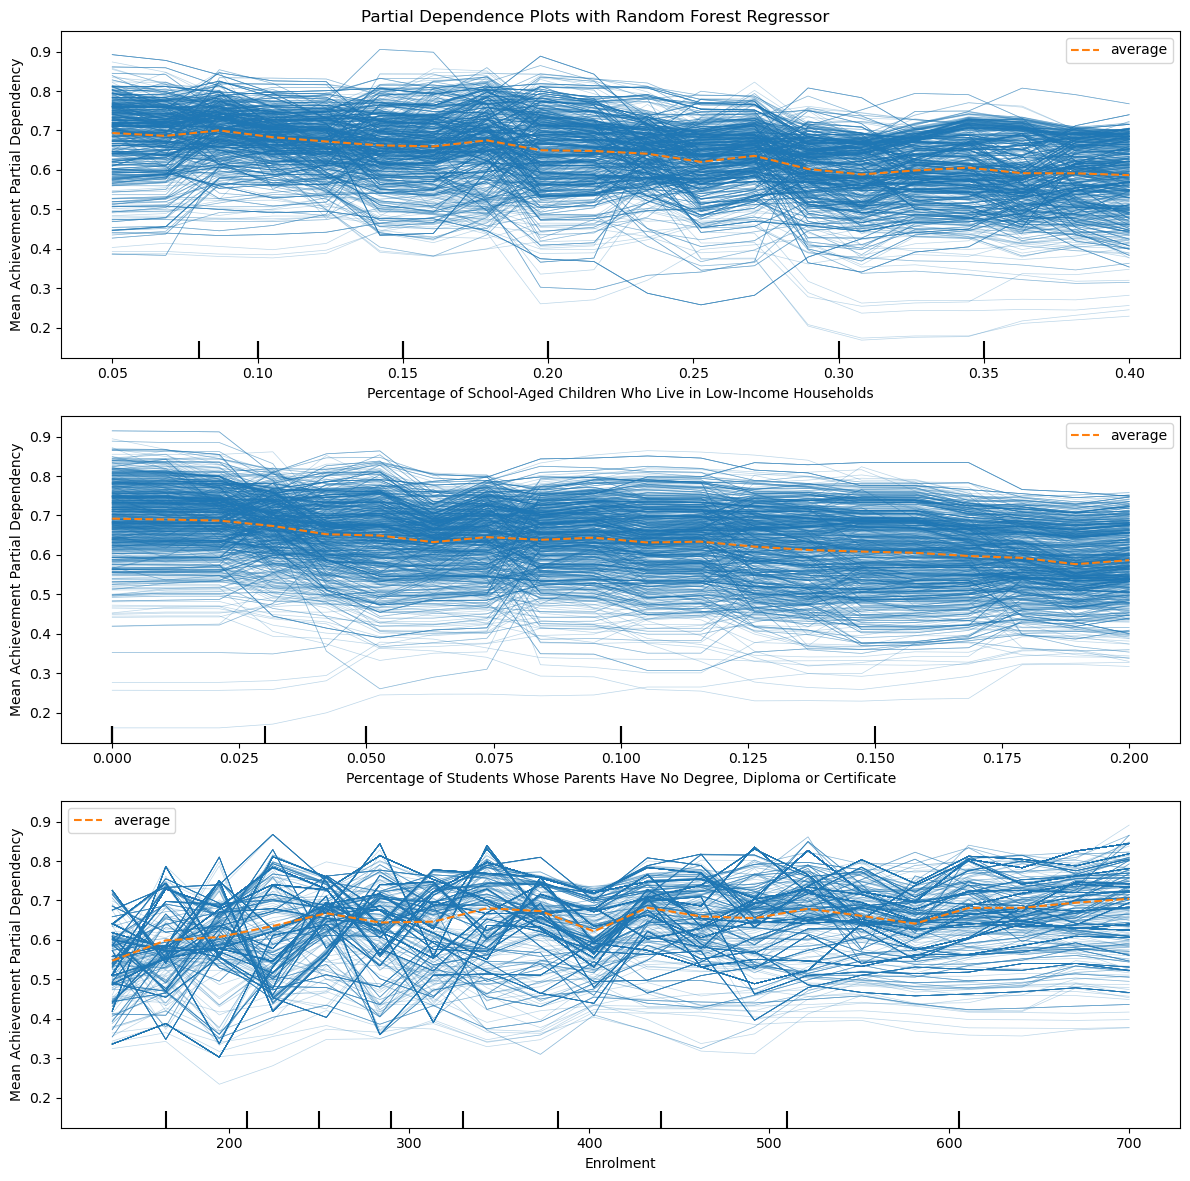

In [5]:
features = ['Percentage of School-Aged Children Who Live in Low-Income Households',
            'Percentage of Students Whose Parents Have No Degree, Diploma or Certificate',
            'Enrolment']

fig, axs = plt.subplots(len(features), figsize=(12, len(features) * 4))
if len(features) == 1:
    axs = [axs]

display = PartialDependenceDisplay.from_estimator(
    rf_regressor,
    X=X_train,
    features=features,
    kind="both",
    ax=axs,
    grid_resolution=20
)

for ax in axs:
    ax.set_ylabel('Mean Achievement Partial Dependency')

plt.suptitle('Partial Dependence Plots with Random Forest Regressor')
plt.tight_layout()
plt.show()

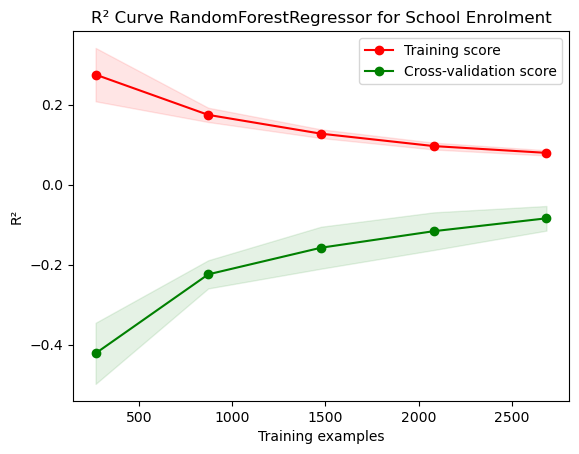

In [6]:
def plot_learning_curve(estimator, X, y, cv, scoring, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("R²")
    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

X_enrolment = data[['Enrolment']]
y = data['Mean Achievement']
rf_regressor_enrolment = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_enrolment.fit(X_enrolment, y)

plot_learning_curve(rf_regressor_enrolment, X_enrolment, y, cv=5, scoring='r2',
                    title="R² Curve RandomForestRegressor for School Enrolment")

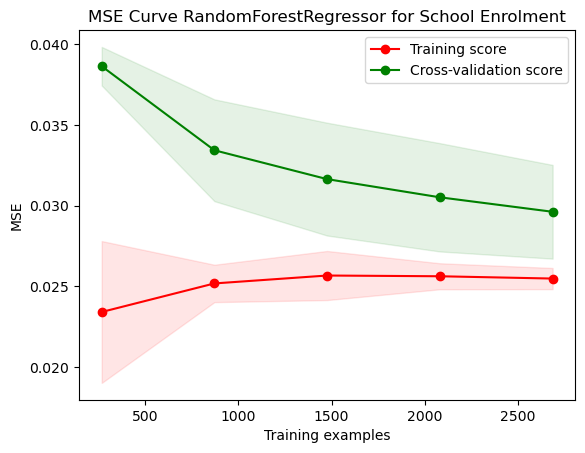

In [7]:
def plot_learning_curve_mse(estimator, X, y, cv, scoring, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring=scoring)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

plot_learning_curve_mse(rf_regressor_enrolment, X_enrolment, y, cv=5, scoring='neg_mean_squared_error',
                        title="MSE Curve RandomForestRegressor for School Enrolment")

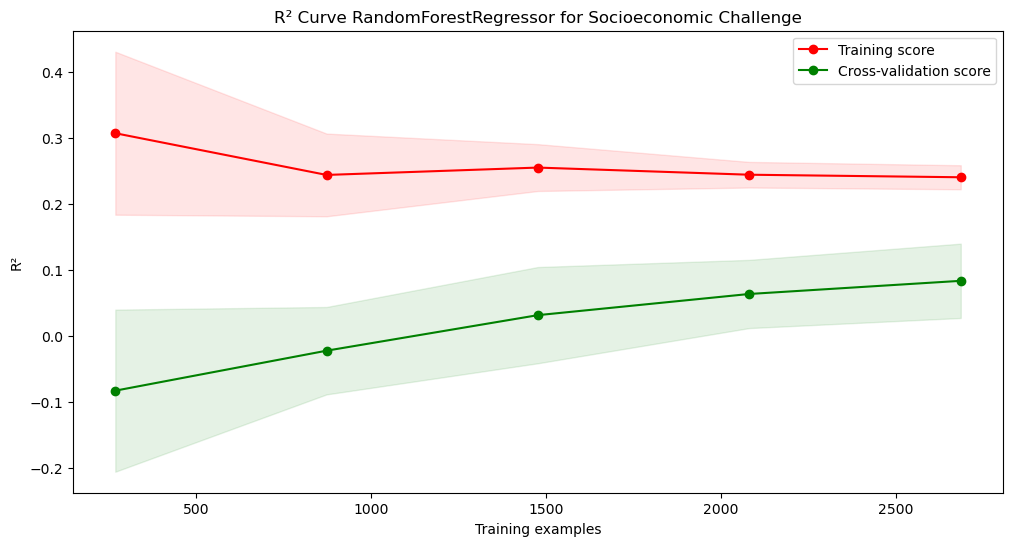

In [8]:
def plot_learning_curve_r2(estimator, X, y, cv, title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("R²")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='r2', n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

X_socio = data[['Percentage of School-Aged Children Who Live in Low-Income Households',
                'Percentage of Students Whose Parents Have No Degree, Diploma or Certificate']]
y_socio = data['Mean Achievement']

rf_regressor_socio = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor_socio.fit(X_socio, y_socio)

plot_learning_curve_r2(rf_regressor_socio, X_socio, y_socio, cv=5, 
                       title="R² Curve RandomForestRegressor for Socioeconomic Challenge")

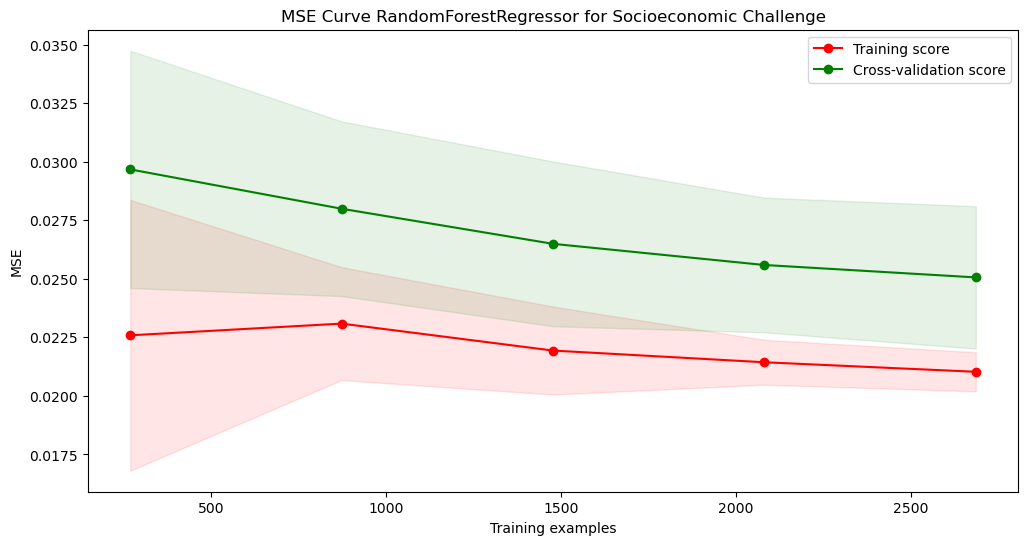

In [9]:
def plot_learning_curve_mse(estimator, X, y, cv, title):
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

plot_learning_curve_mse(rf_regressor_socio, X_socio, y_socio, cv=5, 
                        title="MSE Curve RandomForestRegressor for Socioeconomic Challenge")

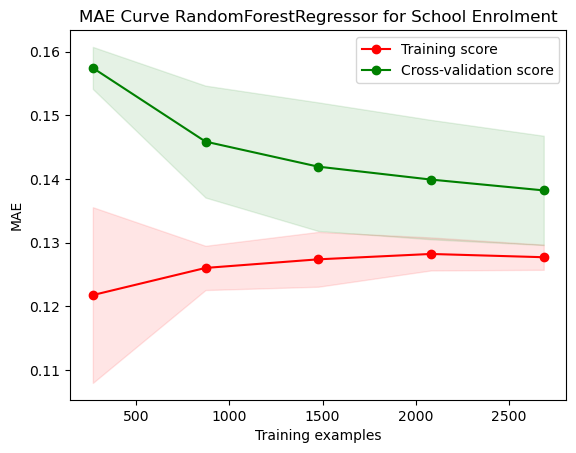

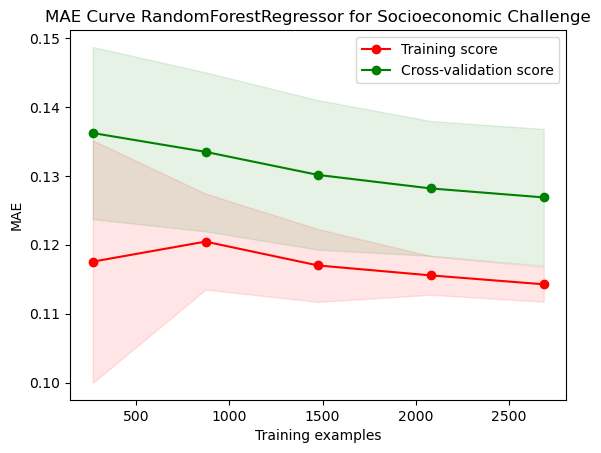

In [10]:
def plot_learning_curve_mae(estimator, X, y, cv, title, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("MAE")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

plot_learning_curve_mae(rf_regressor_enrolment, X_enrolment, y, cv=5, title="MAE Curve RandomForestRegressor for School Enrolment")

plot_learning_curve_mae(rf_regressor_socio, X_socio, y_socio, cv=5, title="MAE Curve RandomForestRegressor for Socioeconomic Challenge")